# micrograd

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5)
ys = f(xs)
plt.plot(xs, ys)

The derivative of a function ***f(x)*** is the amount ***f(x)*** changes when a small value ***h*** is added to ***x***, as ***h*** approaches `0`.
$$ \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

In [ ]:
h = 0.000001
x = 2/3
(f(x+h) - f(x)) / h # Dividing by h 'normalizes' the difference

In [ ]:
# More complex function d(a, b, c) = a * b + c
h = 0.0001

# Inputs
a = 2.0
b =  -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1:", d1)
print("d2:", d2)
print("Slope:", (d2-d1)/h)
# Note: da/dd = b = -3.0
# Note: db/dd = a = 2.0
# Note: dc/dd = so the slope will be 1

In [47]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad = other.grad * out.grad
            other.grad = self.grad * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        tanh_x = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=tanh_x, _children=(self,), _op='tanh')

        def _backward():
            local_grad = 1 - tanh_x**2
            print("Local Grad:", local_grad)
            self.grad = local_grad * out.grad
        out._backward = _backward
        return out

# Topological sort
def build_topo(v):
    topo = []
    visited = set()
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    return topo



a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = 'e'   # Intermediate variable for better visualization
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f

L

Value(data=-8.0)

In [34]:
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in the graph"""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR means Left-to-Right
    
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # For any value in the graph create a rectangular ('record') node for it
        dot.node(name=uid, label=f"{{{node.label} | data: {node.data:.4f} | grad: {node.grad:.4f} }}", shape="record")
        if node._op:
            # If this value is the result of an operation, create an op node for it
            dot.node(name = uid + node._op, label = node._op)
            # and connect this node to it.
            dot.edge(uid + node._op, uid)
    
    for parent, child in edges:
        # Connect the parent to the op node of it's child
        dot.edge(str(id(parent)), str(id(child)) + child._op)
    return dot

## Simple Neuron

![Simple Neuron]("static/simple_neuron.jpeg")

In [56]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432)

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

# Activation function
o = n.tanh()
o.label = 'o'


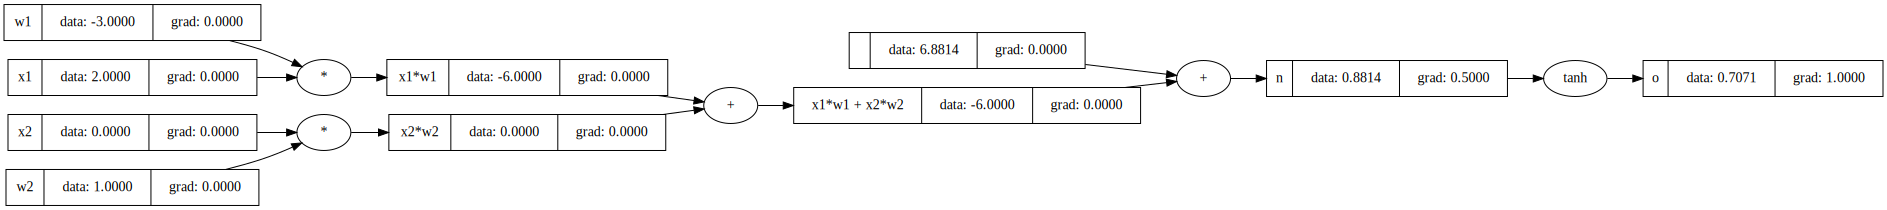

In [59]:
draw_dot(o)

In [58]:
o.grad = 1
o._backward()

Local Grad: 0.4999999999999999


## Topological Sort

This allows you sort out a graph such that all the edges go from left to right, this allows us call `_backward` through our computational graph in the right order. It's done in `build_topo`